In [1]:
# Imports

In [2]:
import sys
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import read_h5ad
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import pickle
import numpy as np
import pandas as pd
import os
import scanpy as sc
from anndata import read_h5ad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tqdm.auto import tqdm
import seaborn as sns
import pyranges as pr
from scipy import sparse, stats

In [4]:
# import atac-metacell-utilities functions
sys.path = ["../src"] + sys.path
from pl import enhancer_plot, setup_cmap_and_legend, discretize_colors
from util import load_module
from density_analysis import density_analysis as da

In [5]:
n_genes = 100
min_peaks = 4
target_lineage = 'Bcells'
target_fate = 'proB'
base_fate = 'HSC'
dorc_pval = 1.0

In [6]:
#! aws s3 sync s3://fh-pi-setty-m-eco-public/mellon-tutorial/  ../data/

In [7]:
#TODO: get stuff from Anndata

In [8]:
data_dir = "../data/"
rna_annData_file = data_dir + "preprocessed_t-cell-depleted-bm-rna.h5ad" 
atac_annData_file =  data_dir + "preprocessed_t-cell-depleted-bm-atac.h5ad" 

peak_file = f'../results/diff_acc/{target_fate}_{base_fate}_diff_acc.tsv'
gene_peak_scores_file = '/fh/fast/setty_m/user/cjordan2/repositories/density-analysis/data/tcell_dep_gene_peak_corrs.p'
fate_dict_file = '/fh/fast/setty_m/user/msetty/projects/sc-density/data/bone-marrow-tcelldep/lineage_cells.p'

In [9]:
rna_ad = read_h5ad(rna_annData_file)
atac_ad = read_h5ad(atac_annData_file)

In [10]:
atac_ad

AnnData object with n_obs × n_vars = 8627 × 216477
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'Bcells_primed', 'Bcells_lineage_specific'
    uns: 'FIMOColumns', 'GeneScoresColumns', 'InSilicoChipColumns', 'celltype_colors', 'celltype_combined_colors', 'leiden', 'leiden_colors', 'neighbors', 'phenograph_colors', 'tab20', 'umap'
    obsm: 'DM_EigenVectors', 'GeneScores', 'X_svd', 'X_umap'
    varm: 'FIMO', 'InSilicoChip', 'InSilicoChip_Corrs', 'OpenPeaks'
    layers: 'tf_idf'
    obsp: 'ImputeWeights', 'connectiv

In [11]:
peaks = pd.read_csv(peak_file, sep = "\t", index_col= 0)
peaks = peaks[atac_ad.var[f'{target_lineage}_primed'] | atac_ad.var[f'{target_lineage}_lineage_specific']]
peaks

/loc/scratch/24691136/ipykernel_20783/4211461503.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = peaks[atac_ad.var[f'{target_lineage}_primed'] | atac_ad.var[f'{target_lineage}_lineage_specific']]


logFC      padj_fdr  groupA_N  groupB_N  \
feature                                                              
chr2:231672408-231672908  -8.459  3.200000e-23       6.0       3.0   
chr19:42129437-42129937   -8.392  8.960000e-22       6.0       3.0   
chr5:139747147-139747647  -5.545  8.960000e-22       6.0       3.0   
chr10:124601330-124601830 -8.339  1.530000e-20       6.0       3.0   
chr12:123131799-123132299 -8.347  2.140000e-20       6.0       3.0   
...                          ...           ...       ...       ...   
chrX:68432583-68433083     0.000  1.000000e+00       NaN       NaN   
chrX:71112012-71112512     0.000  1.000000e+00       NaN       NaN   
chrX:7146660-7147160       0.000  1.000000e+00       NaN       NaN   
chrX:78331666-78332166     0.000  1.000000e+00       NaN       NaN   
chrX:9472654-9473154       0.000  1.000000e+00       NaN       NaN   

                           mean_groupA  mean_groupB  
feature                                              
chr2:231672408-231672908          4.56         0.00  
chr19:42129437-42129937           4.38         0.00  
chr5:139747147-139747647          4.68         0.78  
chr10:124601330-124601830         4.58         0.00  
chr12:123131799-123132299         4.52         0.00  
...                                ...          ...  
chrX:68432583-68433083            0.21         0.00  
chrX:71112012-71112512            0.27         0.00  
chrX:7146660-7147160              0.27         0.00  
chrX:78331666-78332166            0.27         0.00  
chrX:9472654-9473154              0.27         0.00  

[18589 rows x 6 columns]

In [12]:
with open(fate_dict_file, 'rb') as f:
    fate_dict = pickle.load(f)

/loc/scratch/24691136/ipykernel_20783/3925085334.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lineages = pd.Series(index = rna_ad.obs_names)


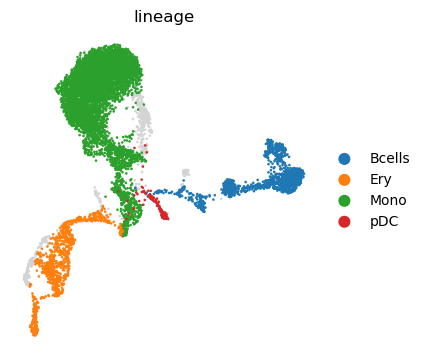

In [13]:
lineages = pd.Series(index = rna_ad.obs_names)
for lineage in fate_dict.keys():
    fate_dict[lineage] = fate_dict[lineage].str.replace('rep1','IM-1393_BoneMarrow_TcellDep_1_multiome', regex = False)
    fate_dict[lineage] = fate_dict[lineage].str.replace('rep2','IM-1393_BoneMarrow_TcellDep_2_multiome',  regex = False)
    lineages[fate_dict[lineage]] = lineage
rna_ad.obs['lineage'] = lineages
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.scatter(rna_ad, basis='umap', color='lineage', frameon = False)

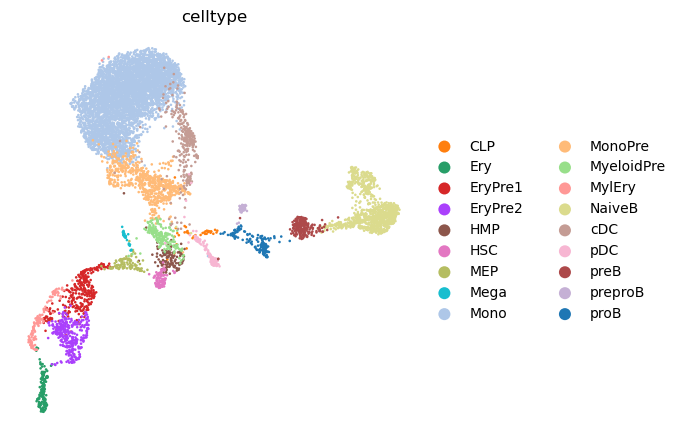

In [14]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.scatter(rna_ad, basis='umap', color='celltype', frameon = False)

In [15]:
with open (gene_peak_scores_file, "rb") as handle:
    gene_peak_scores =pickle.load(handle) #dict(list(atac_ad.uns['gp_corrs'].groupby("gene")))
gp_corr_df = pd.DataFrame()
for gene in tqdm(gene_peak_scores.keys()):
    if type(gene_peak_scores[gene]) != int:
        gene_peak_scores[gene]["gene"] = pd.Series(gene, gene_peak_scores[gene].index)
        gp_corr_df = pd.concat([gp_corr_df, gene_peak_scores[gene]])
atac_ad.uns["gp_corrs"] = gp_corr_df


  0%|          | 0/15959 [00:00<?, ?it/s]

In [16]:
atac_ad.uns['gp_corrs']

cor      pval       gene
chr1:804692-805192       -0.099709  0.849025  LINC01409
chr1:816093-816593        0.520633  0.288132  LINC01409
chr1:817087-817587        0.609596  0.229494  LINC01409
chr1:821956-822456        0.085440  0.154738  LINC01409
chr1:827308-827808        0.089811  0.416785  LINC01409
...                            ...       ...        ...
chrX:155889265-155889765 -0.062501  0.839626      VAMP7
chrX:155891422-155891922  0.520514  0.107698      VAMP7
chrX:155893560-155894060  0.225227  0.373875      VAMP7
chrX:155899254-155899754  0.326659  0.304601      VAMP7
chrX:155966817-155967317 -0.357303  0.993738      VAMP7

[541694 rows x 3 columns]

# Preparing data

In [17]:
atac_ad.raw = atac_ad

In [18]:
sc.pp.normalize_total(atac_ad)

In [19]:
def log_transform(X, ps=0.1):
    return np.log2(X + ps) - np.log2(ps)

In [20]:
atac_ad.X = sparse.csr_matrix(log_transform(atac_ad.X.todense()))

In [21]:
cell_idx = rna_ad.obs_names[rna_ad.obs['celltype'] == base_fate]
base_mean = np.mean(np.array(atac_ad[cell_idx, :].X.todense()), axis=0)

In [22]:
def get_peak_deltas(fate, all_deltas, gene_peak_scores, invert_deltas = False):
    dorc_peak_deltas = dict()
    for gene in tqdm(rna_ad.var_names, desc=fate, total=rna_ad.n_vars):
        dorc_peak_deltas[gene] = pd.Series(dtype='float64')
        peak_df = gene_peak_scores.get(gene)
        if peak_df is None or isinstance(peak_df, int):
            continue
        selected_peaks = peak_df[peak_df.index.isin(peaks.index)]
        peak_df = peak_df[peak_df['cor'] >0]
        if len(selected_peaks) == 0:
            continue
        dorc_peak_deltas[gene] = all_deltas[selected_peaks.index].sort_values()
        if invert_deltas == True:
            dorc_peak_deltas[gene] = -dorc_peak_deltas[gene]
            dorc_peak_deltas[gene] = dorc_peak_deltas[gene].sort_values()
    return dorc_peak_deltas

In [23]:
sc.tl.rank_genes_groups(rna_ad, groupby = 'celltype', rankby_abs = True, groups = ['NaiveB'], reference = 'HSC', use_raw = False)
ct_genes = rna_ad.uns['rank_genes_groups']
diff_gene_exp = dict()
for celltype in ['NaiveB']:
    diff_gene_exp[celltype] = da.process_gene_ranks(ct_genes, celltype)


In [24]:
rna_ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped', 'lineage'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap', 'lineage_colors', 'rank_genes_groups'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'D

In [25]:
rna_ad.uns['features'] = pd.read_csv('/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/features.tsv', sep = '\t')

In [26]:
rna_ad.uns['features']
genes = rna_ad.uns['features'][rna_ad.uns['features']['Feature Type'] == 'Gene Expression']
genes = genes[genes['Chromosome'].str.contains('chr', regex = False, na = False)]
genes = genes[genes['gene_name'].isin(rna_ad.var_names)]
genes.index = genes['gene_name']
genes

ENSEMBL ID   gene_name     Feature Type Chromosome     Start  \
gene_name                                                                       
AL627309.1  ENSG00000238009  AL627309.1  Gene Expression       chr1    120931   
AL627309.5  ENSG00000241860  AL627309.5  Gene Expression       chr1    149706   
LINC01409   ENSG00000237491   LINC01409  Gene Expression       chr1    778757   
LINC01128   ENSG00000228794   LINC01128  Gene Expression       chr1    827597   
LINC00115   ENSG00000225880   LINC00115  Gene Expression       chr1    827521   
...                     ...         ...              ...        ...       ...   
AC010889.1  ENSG00000260197  AC010889.1  Gene Expression       chrY  19694605   
KDM5D       ENSG00000012817       KDM5D  Gene Expression       chrY  19744760   
AC010889.2  ENSG00000288049  AC010889.2  Gene Expression       chrY  19744951   
TTTY10      ENSG00000229236      TTTY10  Gene Expression       chrY  20575221   
EIF1AY      ENSG00000198692      EIF1AY  Gene Expression       chrY  20575775   

                 End  
gene_name             
AL627309.1    133723  
AL627309.5    173862  
LINC01409     803934  
LINC01128     860227  
LINC00115     827522  
...              ...  
AC010889.1  19694606  
KDM5D       19744939  
AC010889.2  19744952  
TTTY10      20575362  
EIF1AY      20575794  

[17215 rows x 6 columns]

In [27]:
diff_gene_exp['NaiveB']

pvals      pvals_adj  logfoldchanges      log10p
FCRL1        0.000000e+00   0.000000e+00       37.329556  200.000000
MS4A1       5.637793e-193  2.427916e-189       10.717134  188.614766
NKAIN2       4.626907e-78   2.213975e-75      -14.540007   74.654827
PAX5        9.955049e-111  1.008739e-107       10.172239  106.996221
INPP4B       1.566179e-74   6.580245e-72      -13.621899   71.181758
...                   ...            ...             ...         ...
AL162464.2   1.000000e+00   1.000000e+00        0.000000   -0.000000
AL162464.1   1.000000e+00   1.000000e+00        0.000000   -0.000000
AC008534.1   1.000000e+00   1.000000e+00        0.000000   -0.000000
AC007376.2   1.000000e+00   1.000000e+00        0.000000   -0.000000
TNFRSF9      1.000000e+00   1.000000e+00        0.000000   -0.000000

[17226 rows x 4 columns]

In [28]:
bcell_diff_acc = pd.read_csv("/fh/fast/setty_m/user/cjordan2/repositories/geneTF/results/diff_acc/proB_HSC_diff_acc.tsv", sep = "\t", index_col = 0)
bcell_diff_acc.loc[bcell_diff_acc.index.isin(peaks.index),'logFC']

feature
chr2:231672408-231672908    -8.459
chr19:42129437-42129937     -8.392
chr5:139747147-139747647    -5.545
chr10:124601330-124601830   -8.339
chr12:123131799-123132299   -8.347
                             ...  
chrX:68432583-68433083       0.000
chrX:71112012-71112512       0.000
chrX:7146660-7147160         0.000
chrX:78331666-78332166       0.000
chrX:9472654-9473154         0.000
Name: logFC, Length: 18589, dtype: float64

In [29]:
cell_idx = rna_ad.obs_names[rna_ad.obs["lineage"] == base_fate]
base_mean = np.mean(np.array(atac_ad[cell_idx, :].X.todense()), axis=0)

/home/cjordan2/.conda/envs/density-analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cjordan2/.conda/envs/density-analysis/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [30]:
def get_peak_deltas(fate, all_deltas, gene_peak_scores, invert_deltas = False):
    dorc_peak_deltas = dict()
    for gene in tqdm(rna_ad.var_names, desc=fate, total=rna_ad.n_vars):
        dorc_peak_deltas[gene] = pd.Series(dtype='float64')
        peak_df = gene_peak_scores.get(gene)
        if peak_df is None or isinstance(peak_df, int):
            continue
        selected_peaks = peak_df[peak_df.index.isin(peaks.index)]
        peak_df = peak_df[peak_df['cor'] >0]
        if len(selected_peaks) == 0:
            continue
        dorc_peak_deltas[gene] = all_deltas[selected_peaks.index].sort_values()
        if invert_deltas == True:
            dorc_peak_deltas[gene] = -dorc_peak_deltas[gene]
            dorc_peak_deltas[gene] = dorc_peak_deltas[gene].sort_values()
    return dorc_peak_deltas

In [31]:
fate = target_lineage
cell_idx = rna_ad.obs_names[rna_ad.obs["lineage"] == fate]
fate_mean = np.mean(atac_ad[cell_idx, :].X, axis=0)
all_deltas = bcell_diff_acc.loc[bcell_diff_acc.index.isin(atac_ad.var_names),'logFC'].copy()
dorc_peak_deltas = get_peak_deltas(
    fate, all_deltas, gene_peak_scores, invert_deltas = True
)

Bcells:   0%|          | 0/17226 [00:00<?, ?it/s]

In [32]:
#for key in list(dorc_peak_deltas.keys()):
#    if dorc_peak_deltas[key].empty:
#        dorc_peak_deltas.pop(key)

In [33]:
#Data frame 
gene_info_df = diff_gene_exp['NaiveB']
gene_info_df.rename({"logfoldchanges": "logFC"}, inplace = True, axis = 1)
# Define continuous colors from the dorc_peak_deltas for the current fate.
cont_colors = dorc_peak_deltas

In [34]:
gene_info_df

pvals      pvals_adj      logFC      log10p
FCRL1        0.000000e+00   0.000000e+00  37.329556  200.000000
MS4A1       5.637793e-193  2.427916e-189  10.717134  188.614766
NKAIN2       4.626907e-78   2.213975e-75 -14.540007   74.654827
PAX5        9.955049e-111  1.008739e-107  10.172239  106.996221
INPP4B       1.566179e-74   6.580245e-72 -13.621899   71.181758
...                   ...            ...        ...         ...
AL162464.2   1.000000e+00   1.000000e+00   0.000000   -0.000000
AL162464.1   1.000000e+00   1.000000e+00   0.000000   -0.000000
AC008534.1   1.000000e+00   1.000000e+00   0.000000   -0.000000
AC007376.2   1.000000e+00   1.000000e+00   0.000000   -0.000000
TNFRSF9      1.000000e+00   1.000000e+00   0.000000   -0.000000

[17226 rows x 4 columns]

# Preparing plot

In [35]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 300

# Define a dictionary for colormap and legend elements.
# This will be used for discretely coloring and grouping the data.
cmapdict = {
    "up-regulated": "#D13927",
    "unchanged": (0.7, 0.7, 0.7, 1.0),
    "down-regulated": "#4A7CB5",
}
# Call setup_cmap_and_legend function with the cmapdict to generate colormap and legend elements.
cmap, legend_elements = setup_cmap_and_legend(cmapdict)

# Define a threshold for discretizing colors.
discretize = (-0.02, 0.02)

# Call discretize_colors function to discretize the continuous colors.
# disc_colors is a dictionary of {gene: peak_group_assignments} where each gene is assigned to a peak group.
# The number of different groups is the same as the number of colors defined in cmapdict.
disc_colors = discretize_colors(dorc_peak_deltas, discretize)

# Create an enhancer plot with continuous colors

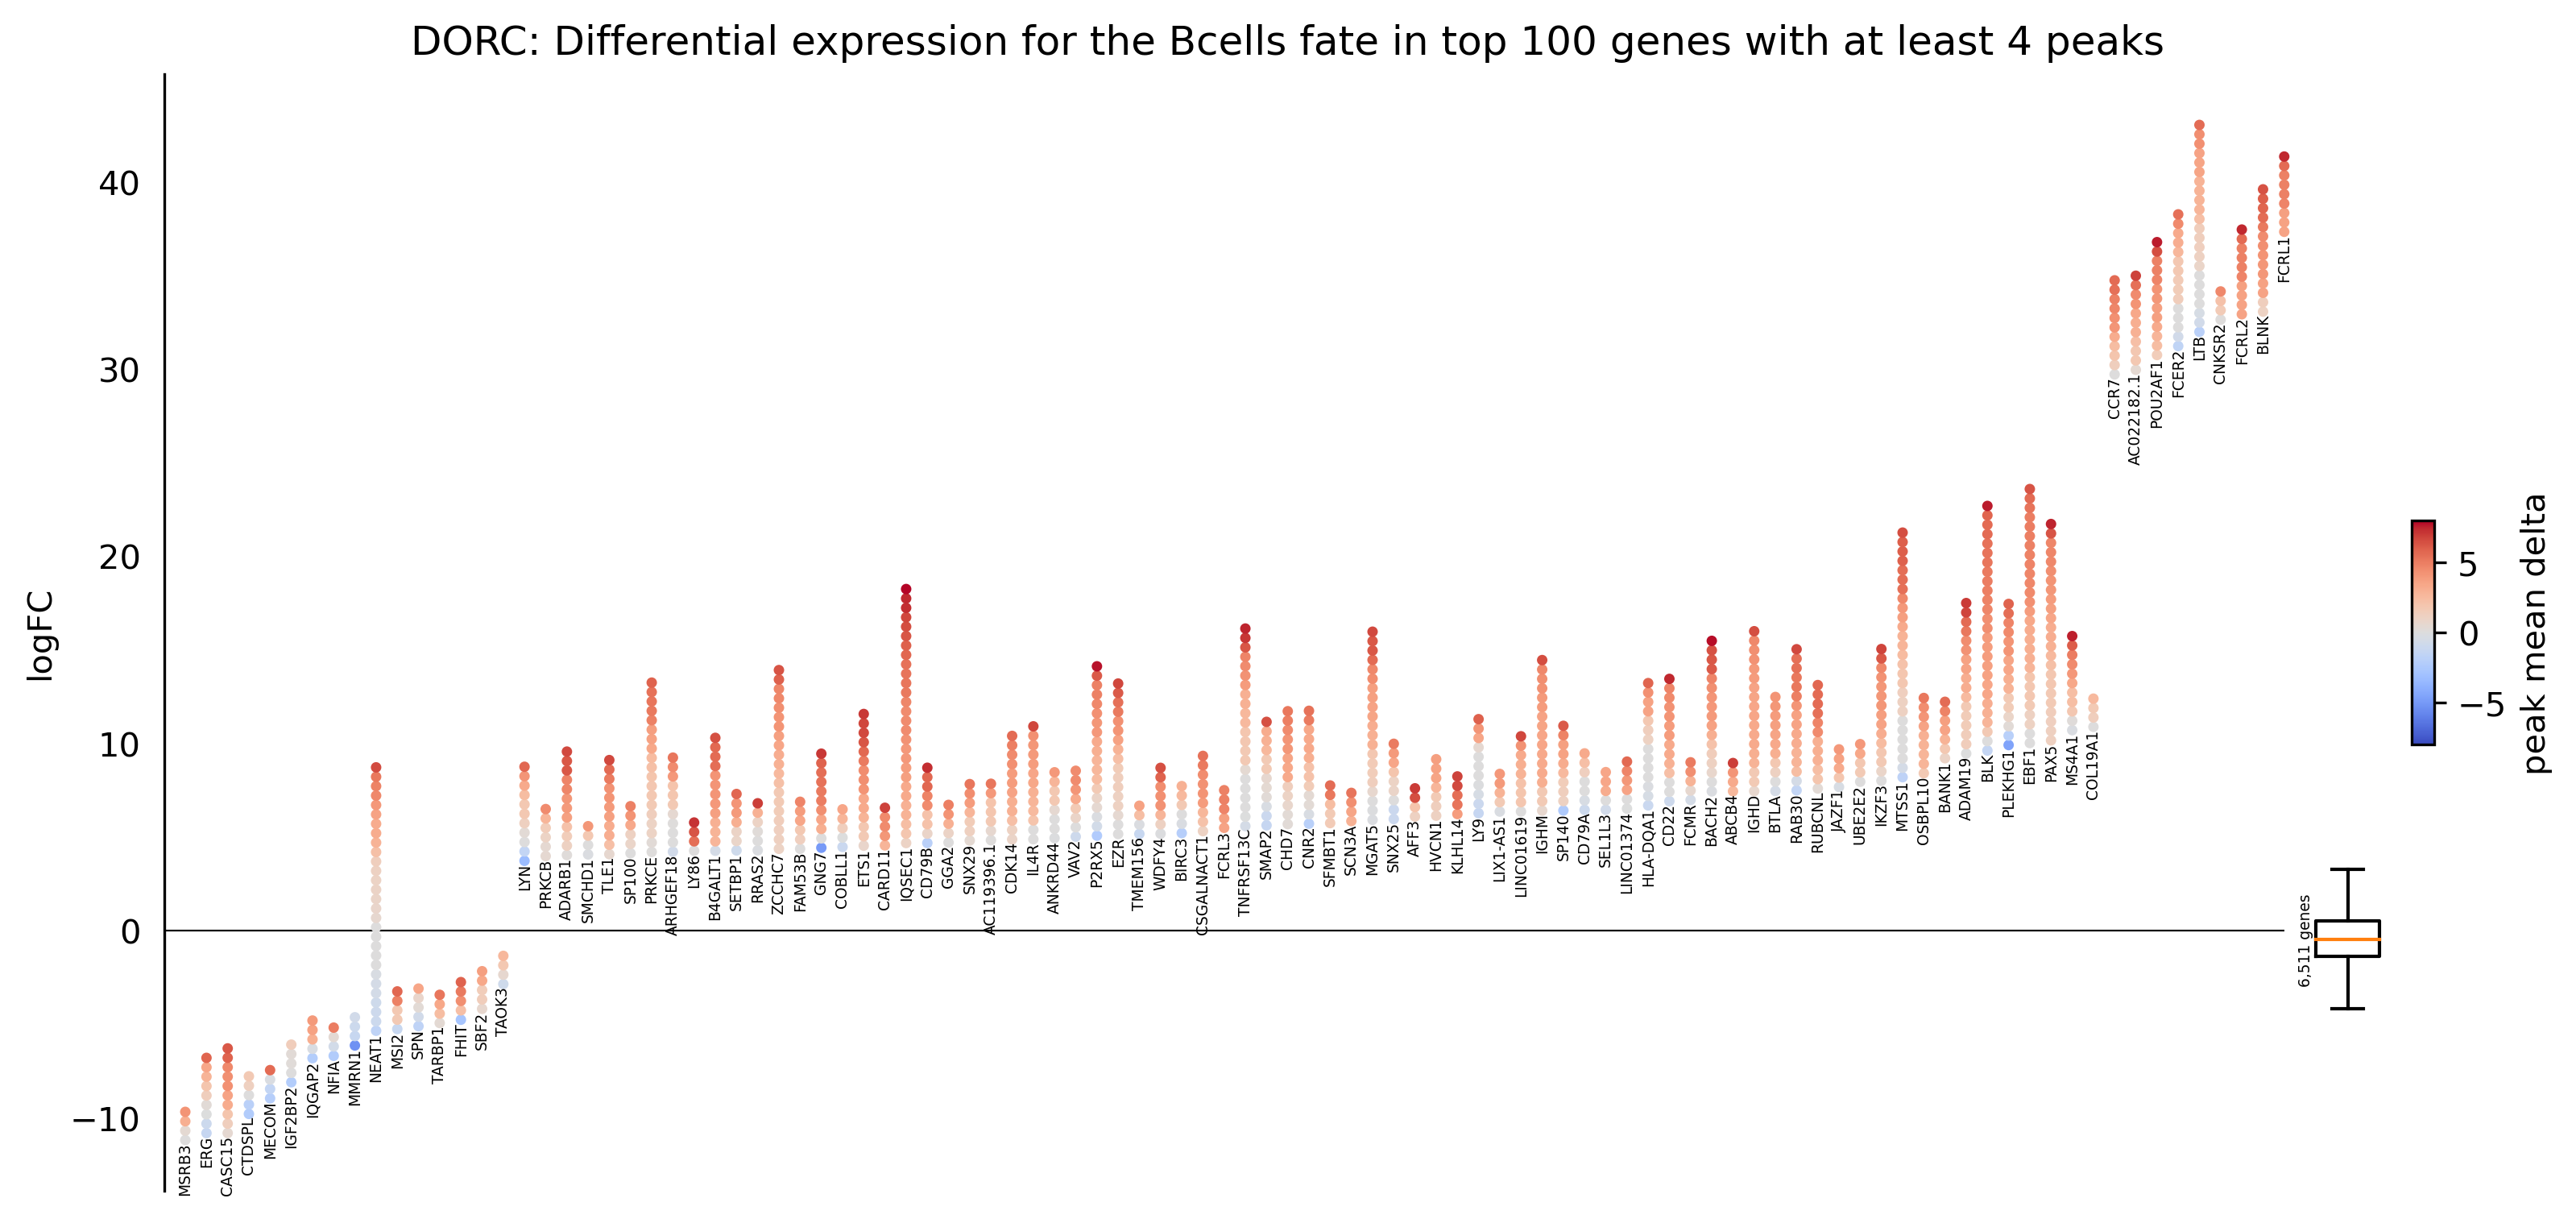

In [36]:
#TODO: find out why continuous colors aren't working
fig, ax, _ = enhancer_plot(
    gene_info_df, cont_colors, n_genes=n_genes, min_peaks=min_peaks
)
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create an enhancer plot with discrete colors

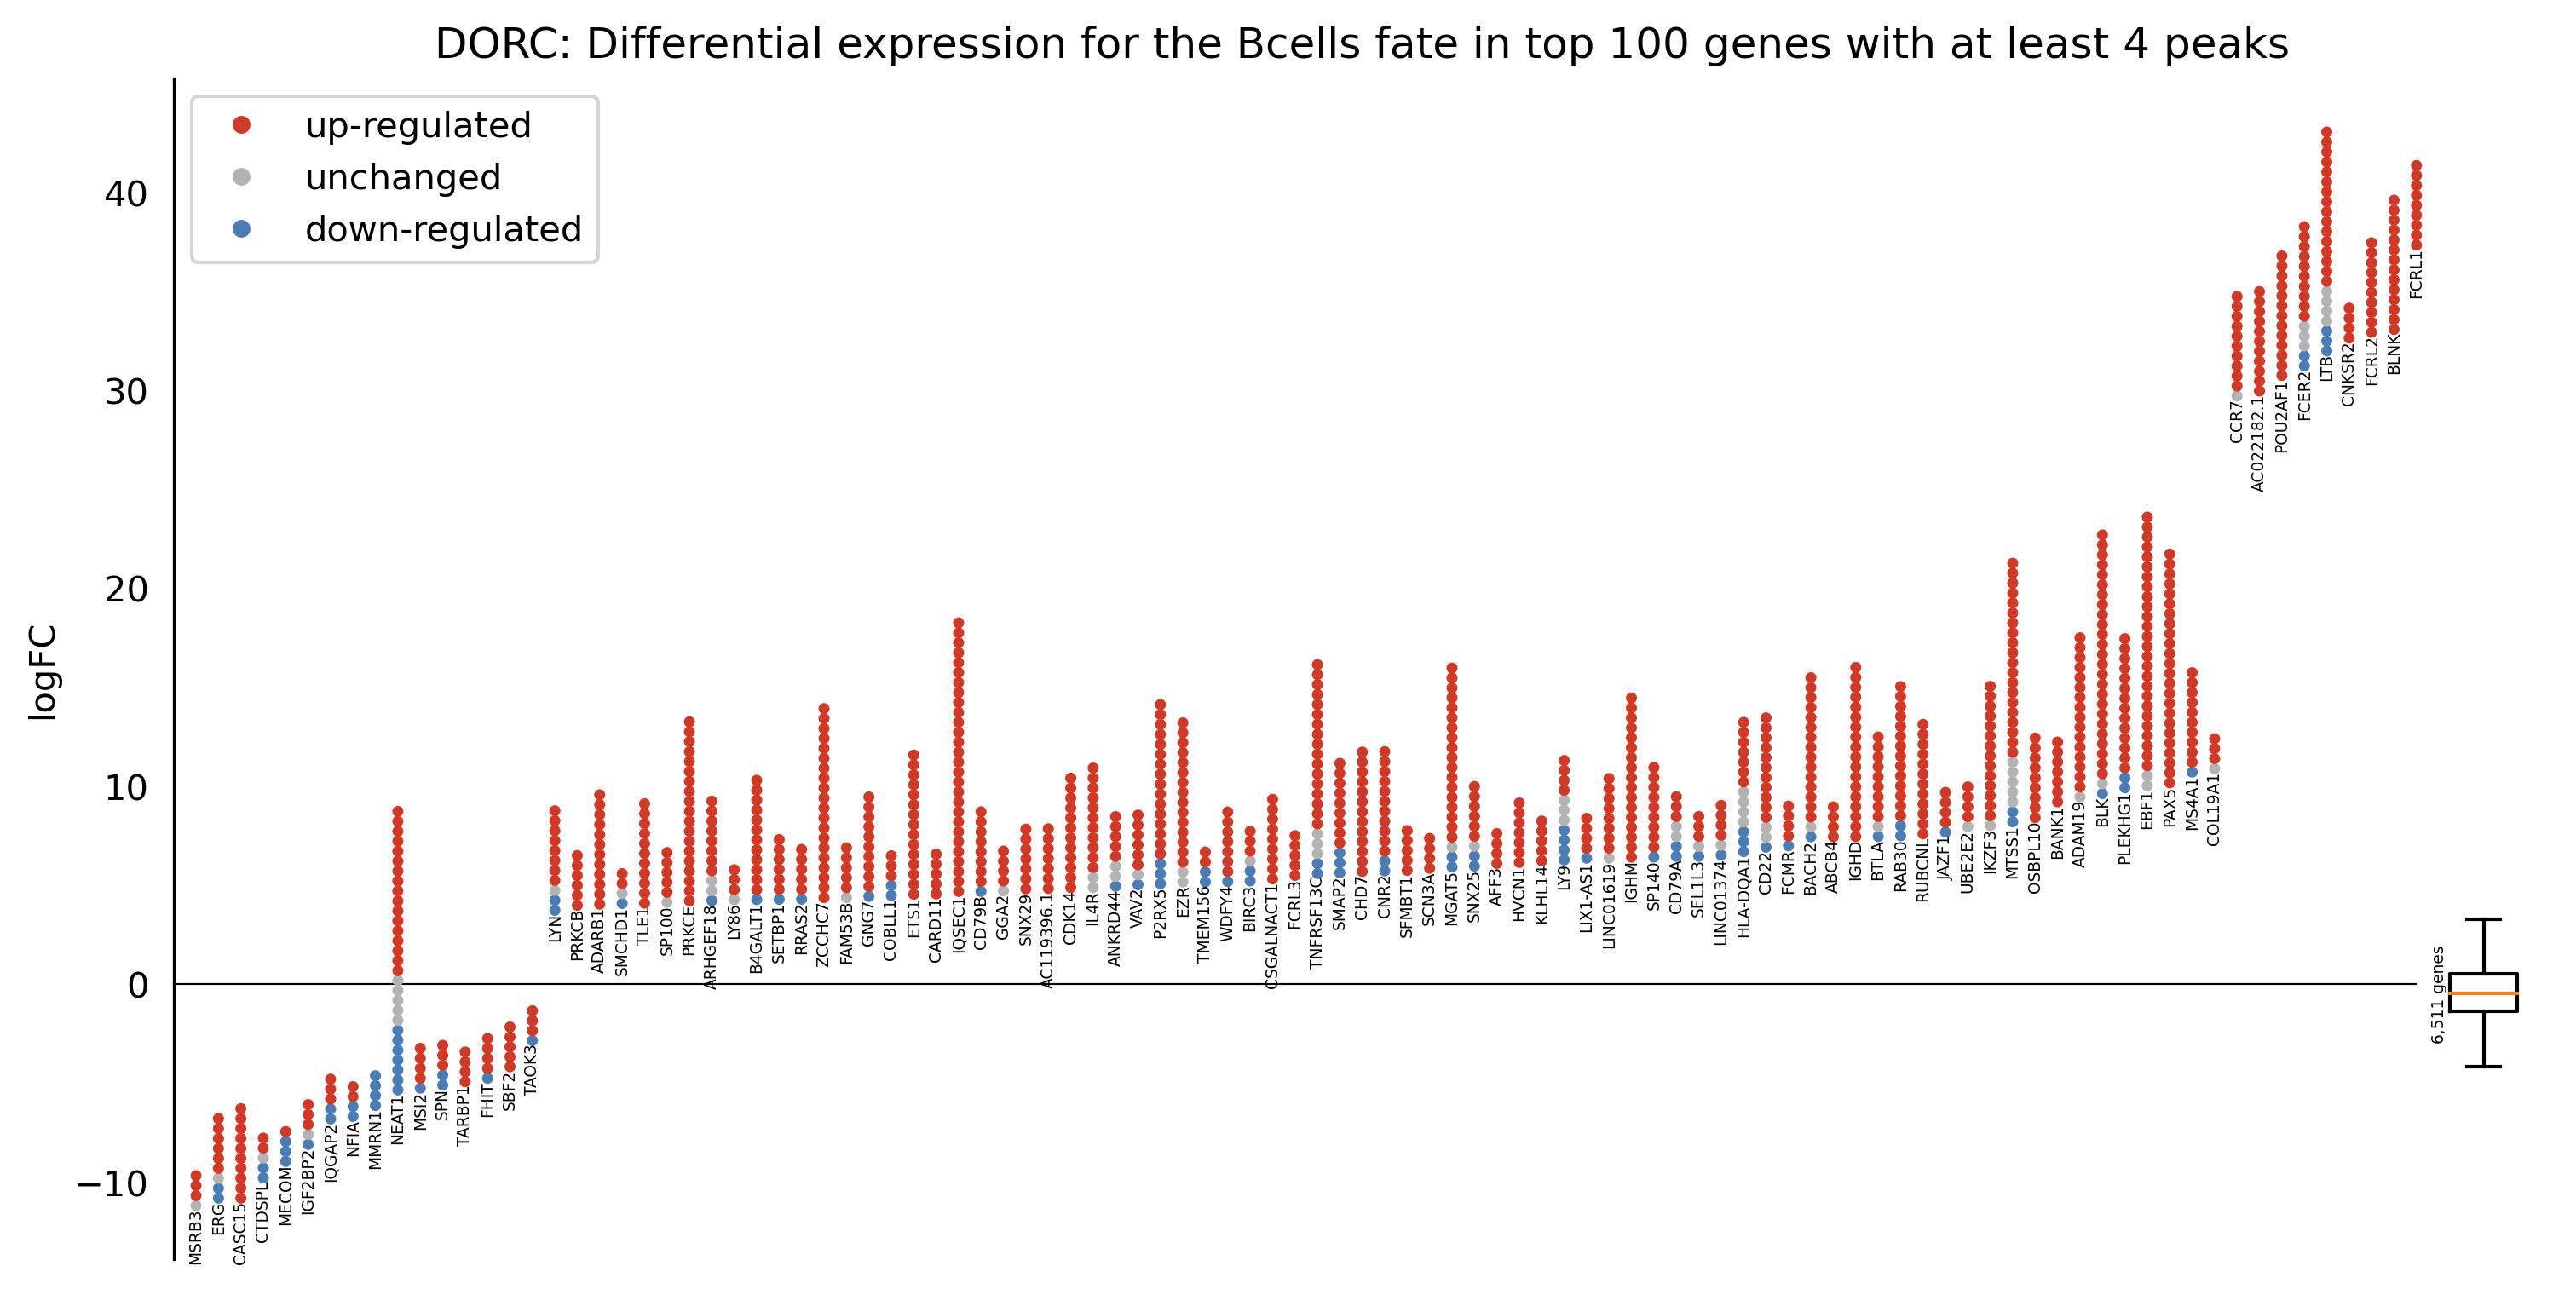

In [37]:
# Here, each gene is represented with a color based on its peak group assignment.
fig, ax, _ = enhancer_plot(
    gene_info_df, disc_colors, n_genes=n_genes, min_peaks=min_peaks, cmap=cmap
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create a grouped enhancer plot with continuous colors

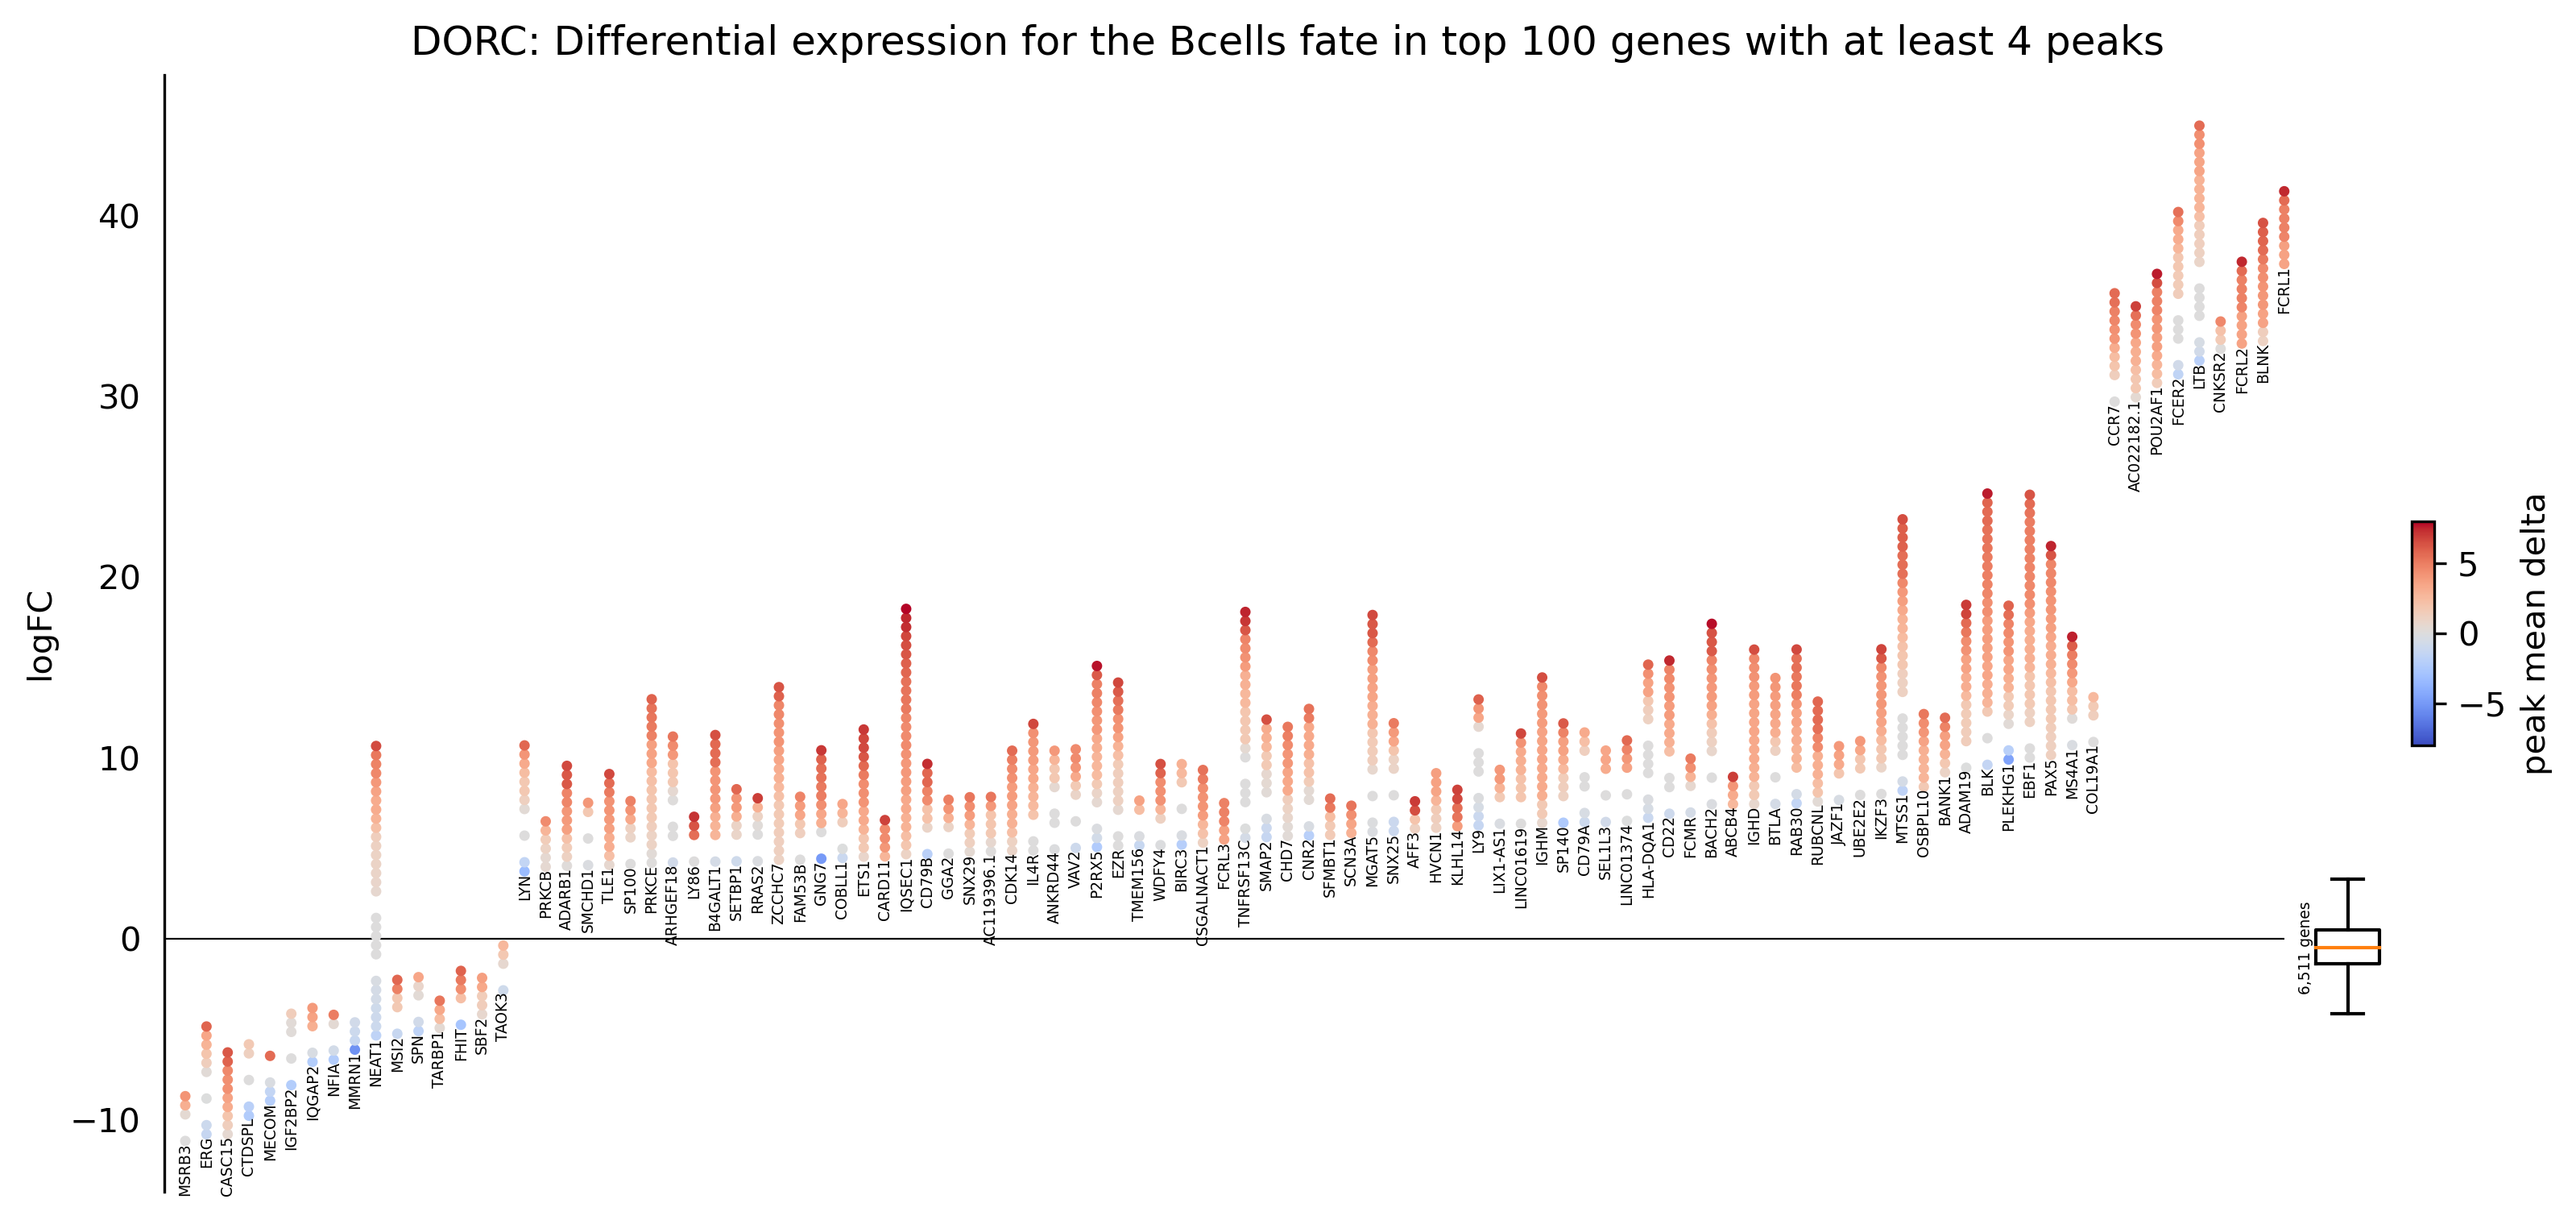

In [38]:
fig, ax, _ = enhancer_plot(
    gene_info_df,
    cont_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
)
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create a grouped enhancer plot with discrete colors

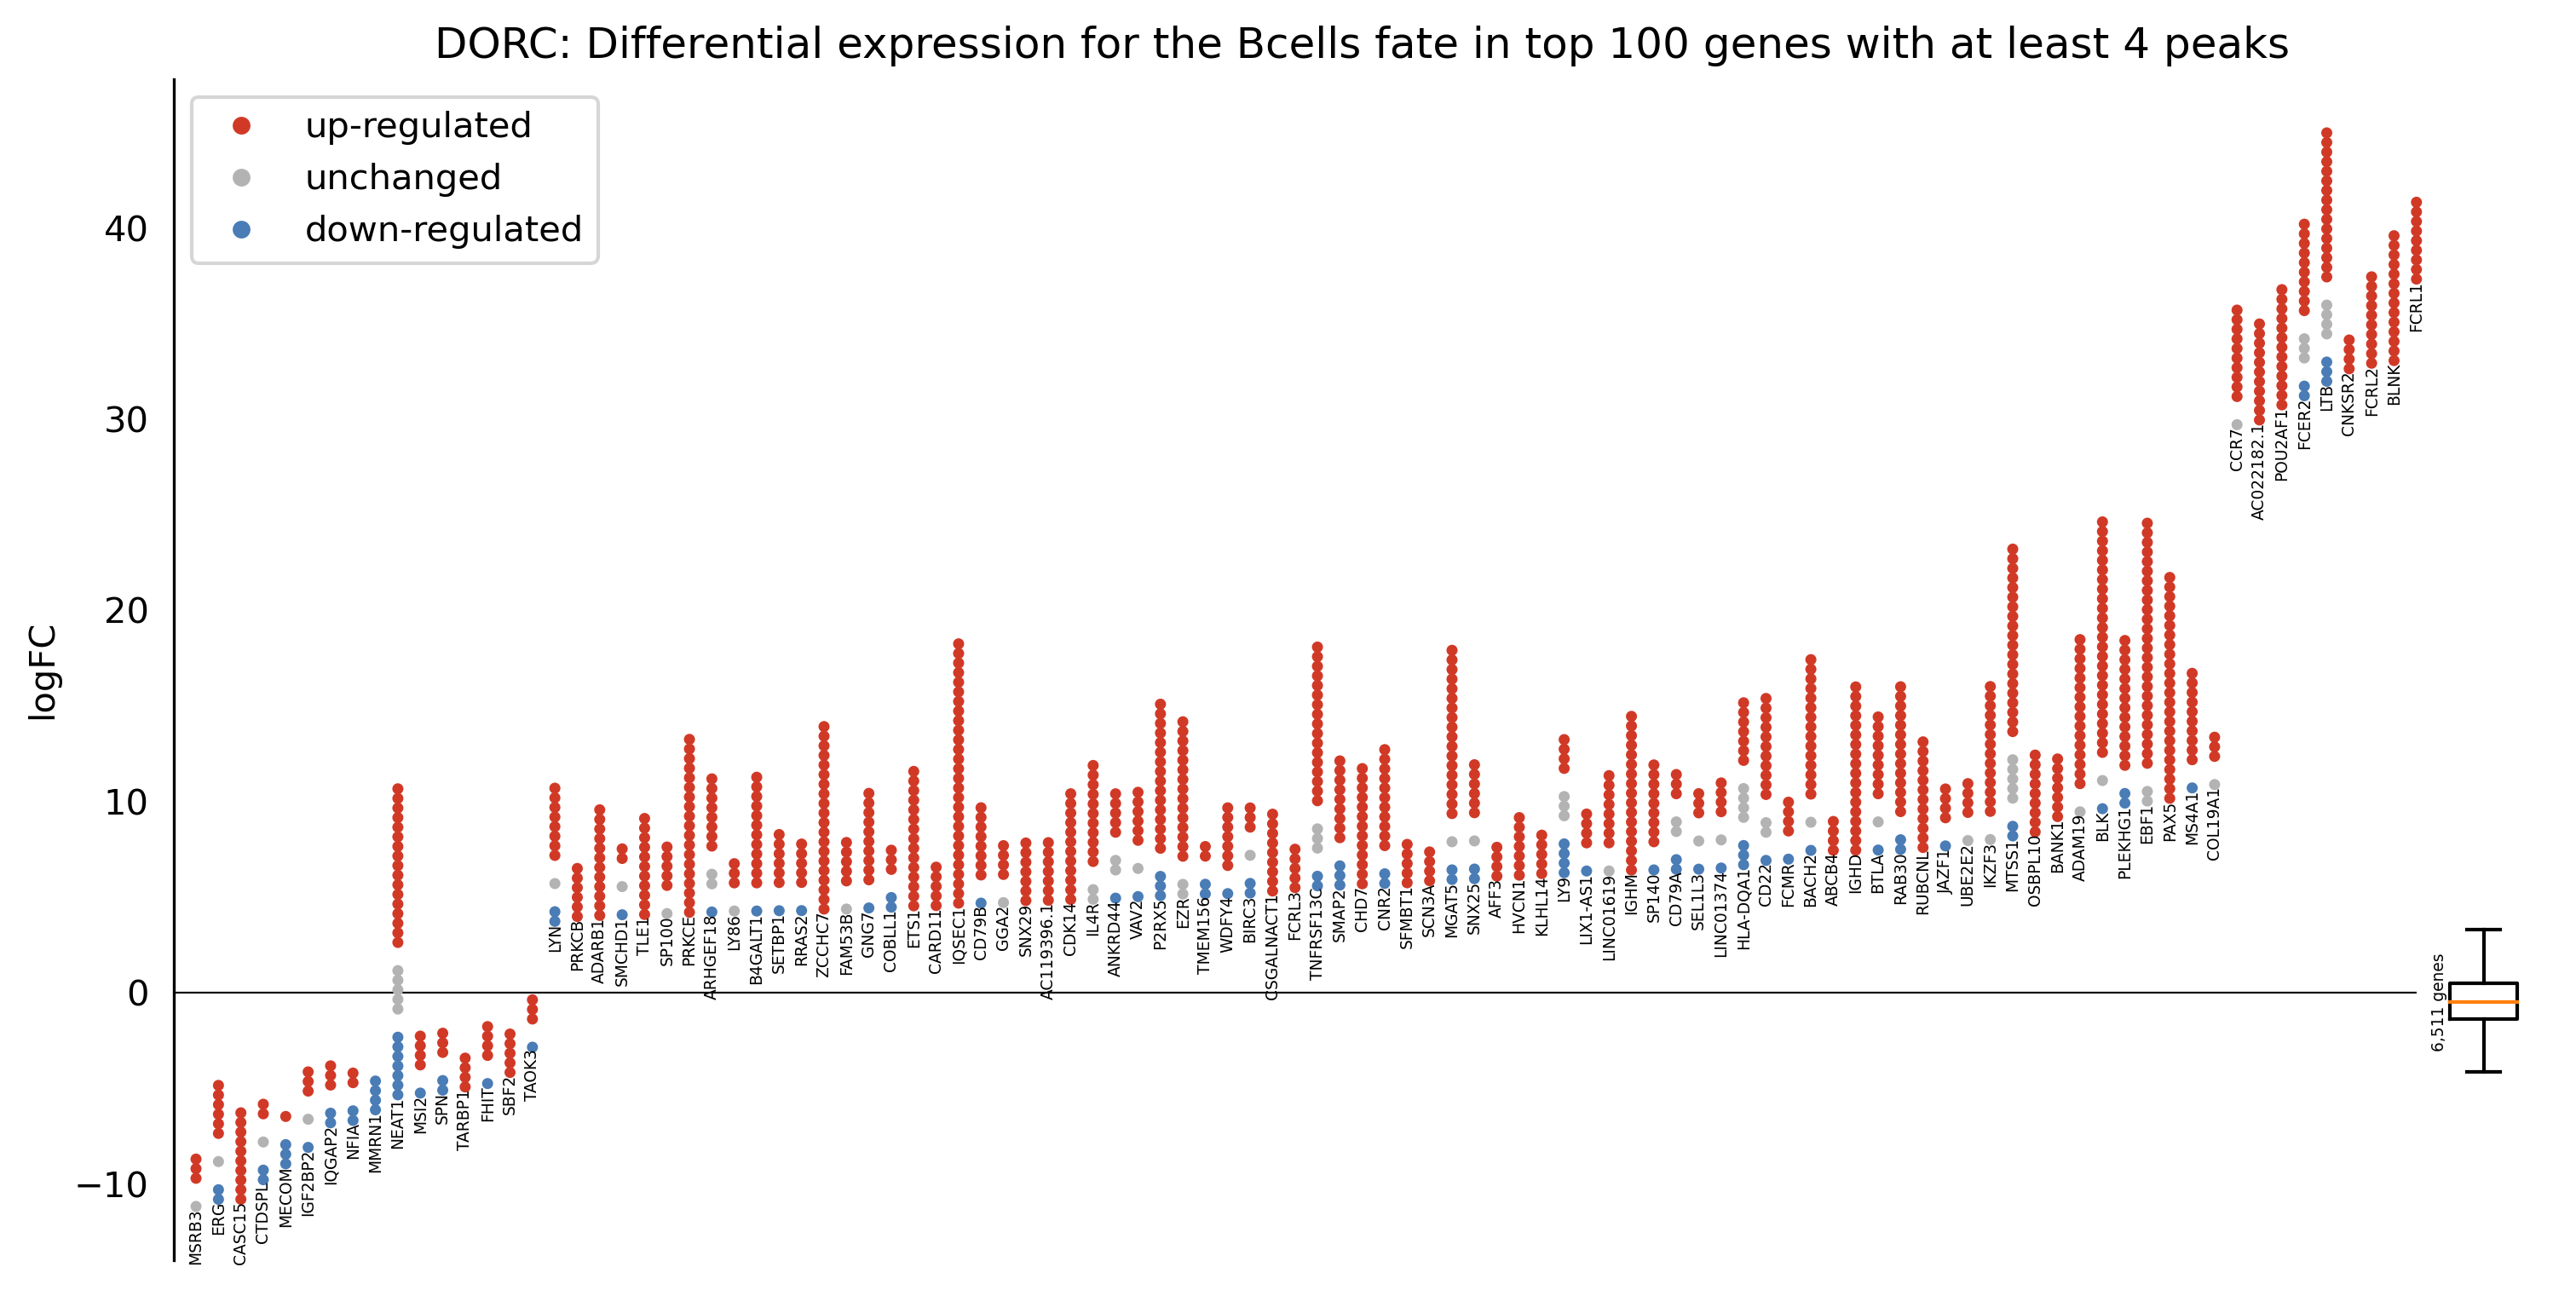

In [39]:
fig, ax, _ = enhancer_plot(
    gene_info_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Show a custom subset of genes

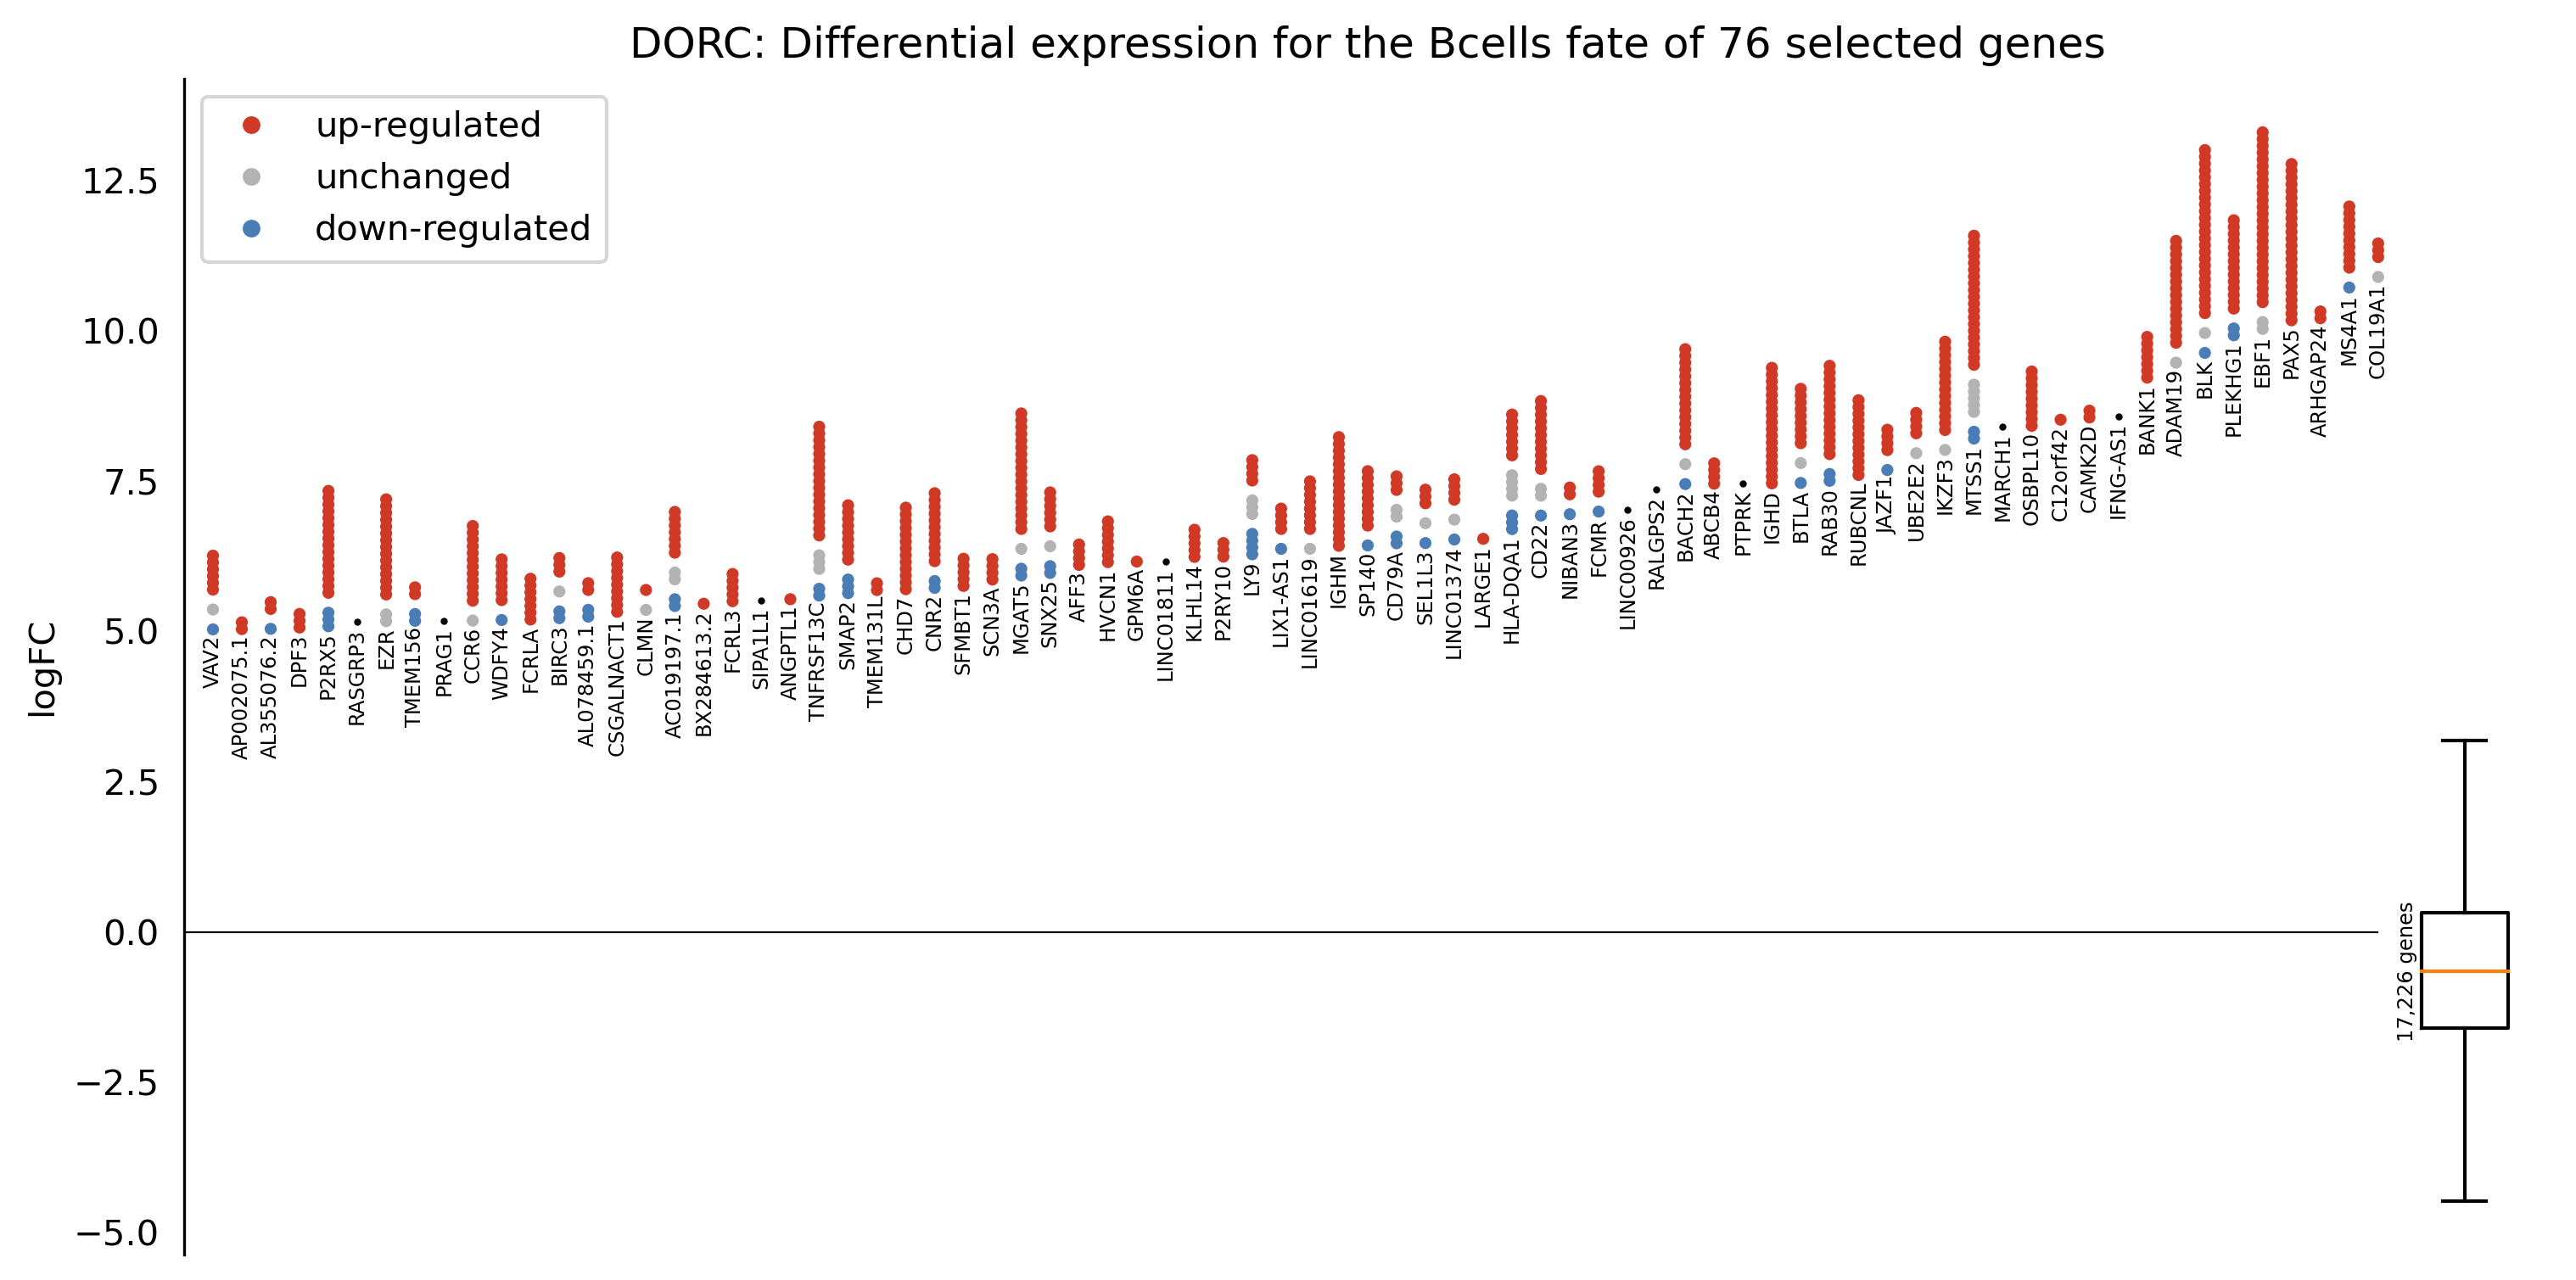

In [40]:
show_mask = (gene_info_df["logFC"]>5) & (gene_info_df["logFC"]<20) # an arbitraty condition
sorted_gene_df = pd.concat(
    [gene_info_df.loc[show_mask, :], gene_info_df.loc[~show_mask, :]]
)
n_selected_genes = int(np.sum(show_mask))
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate of {n_selected_genes} selected genes"
)
plt.show()

# Use alternative markers

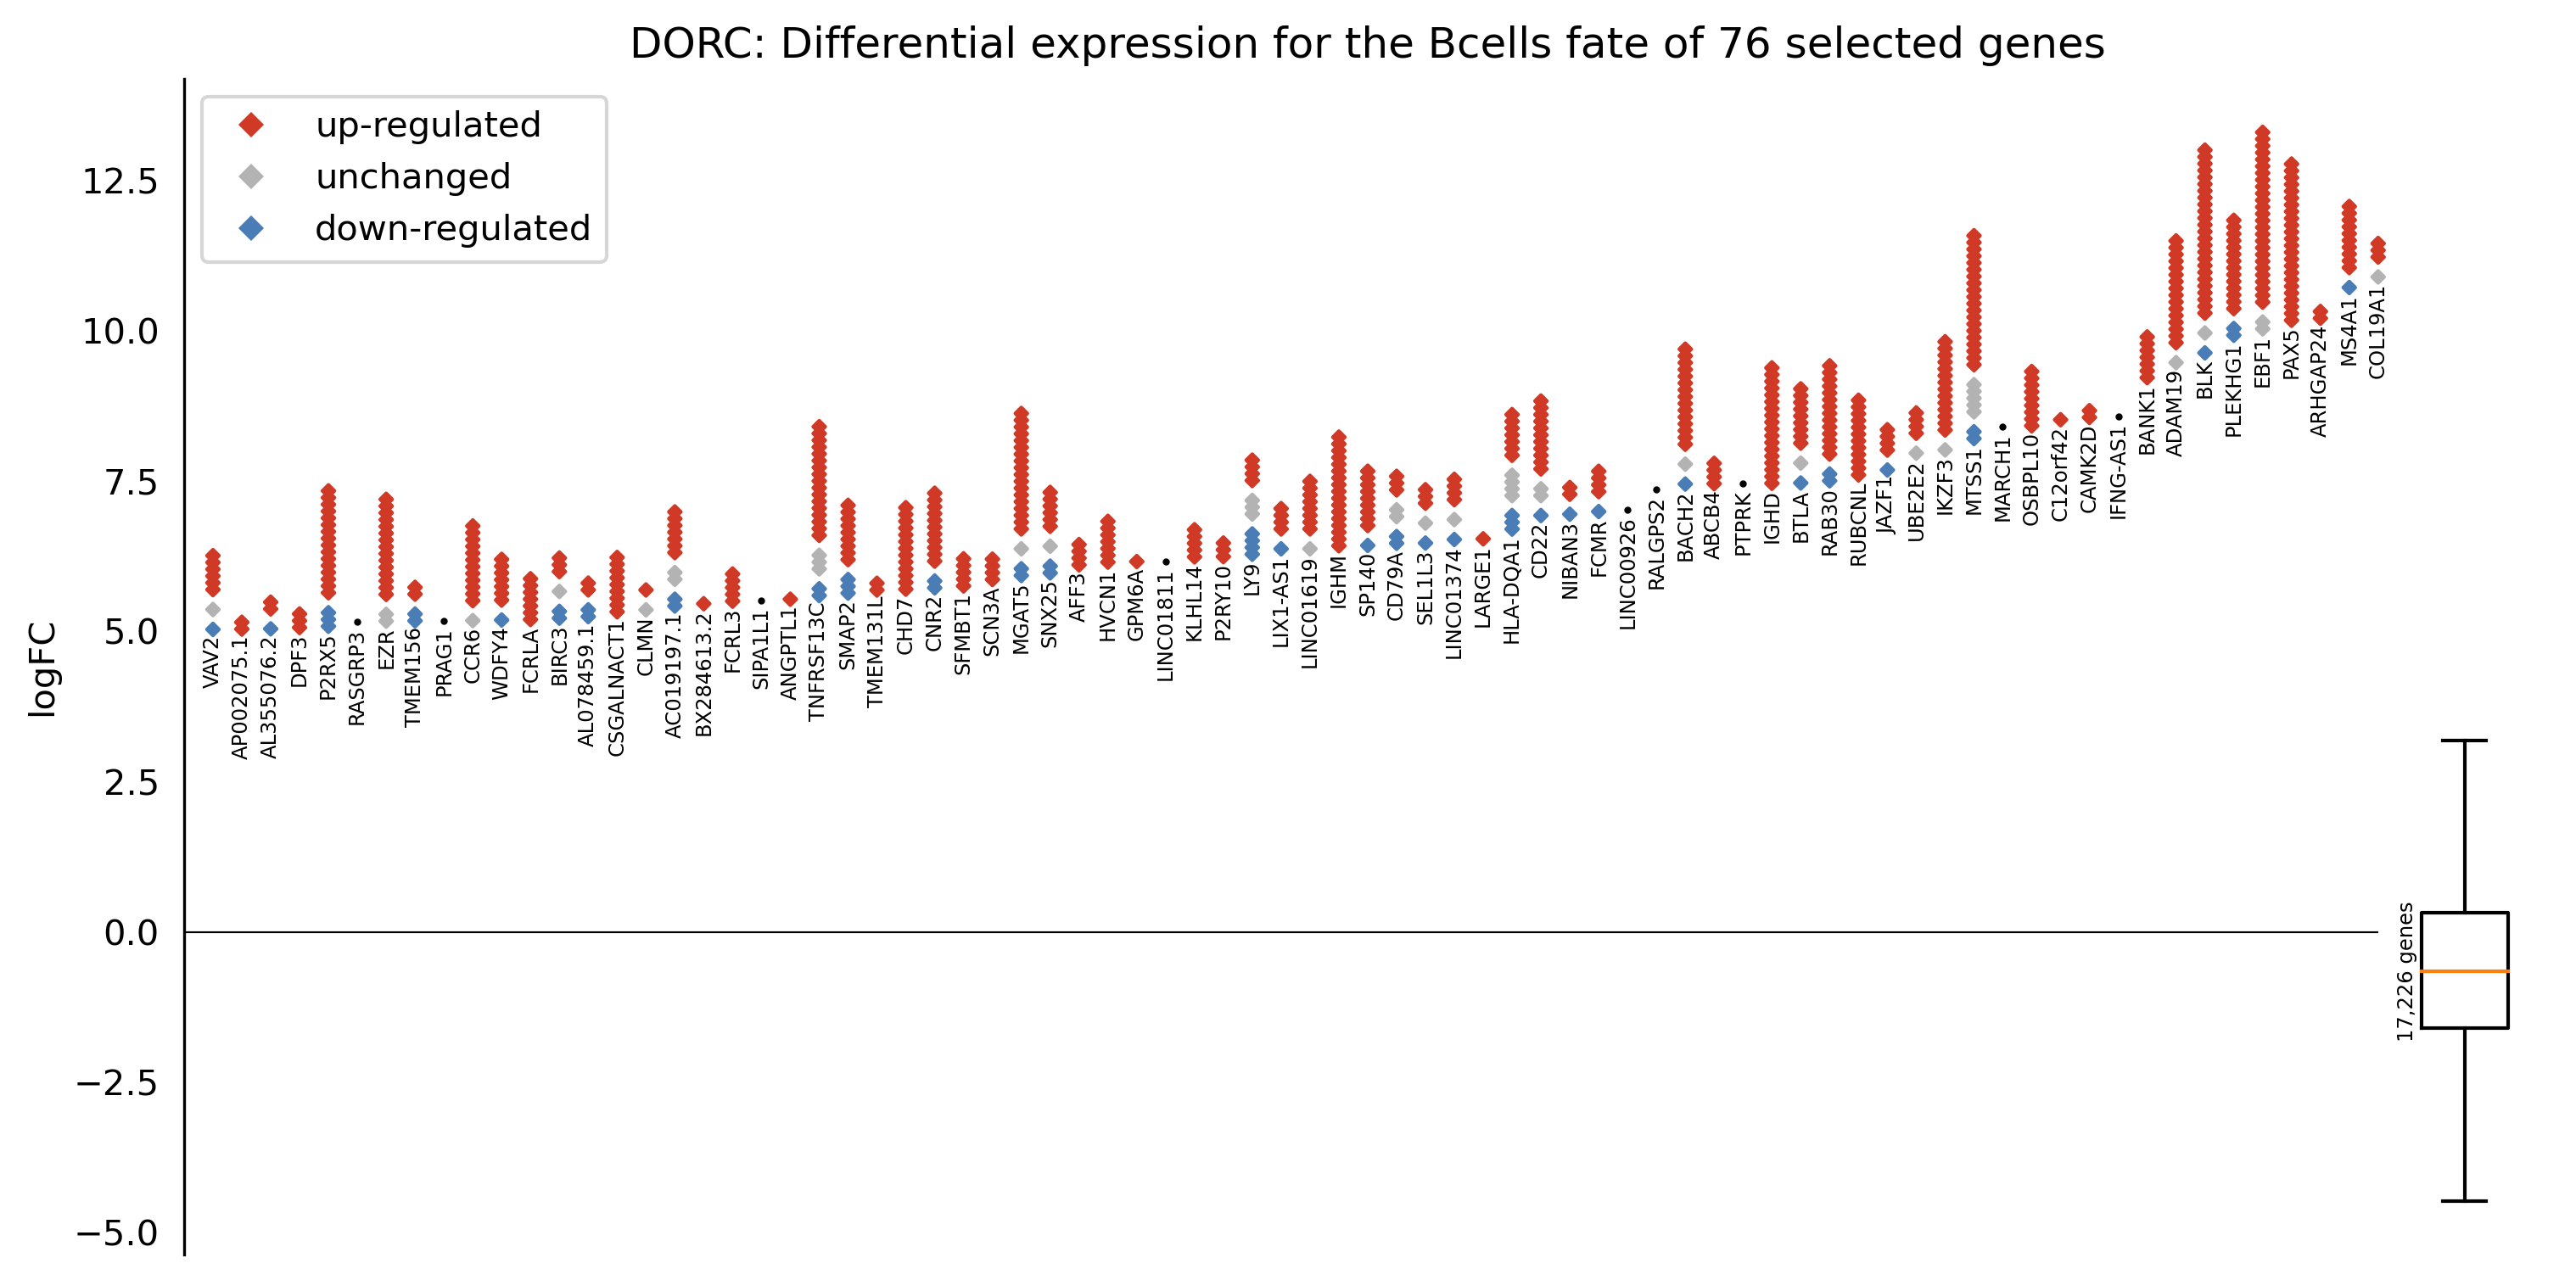

In [41]:
cmap, legend_elements = setup_cmap_and_legend(cmapdict, marker="D")
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    marker="D",
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate of {n_selected_genes} selected genes"
)
plt.show()

# More space between markers

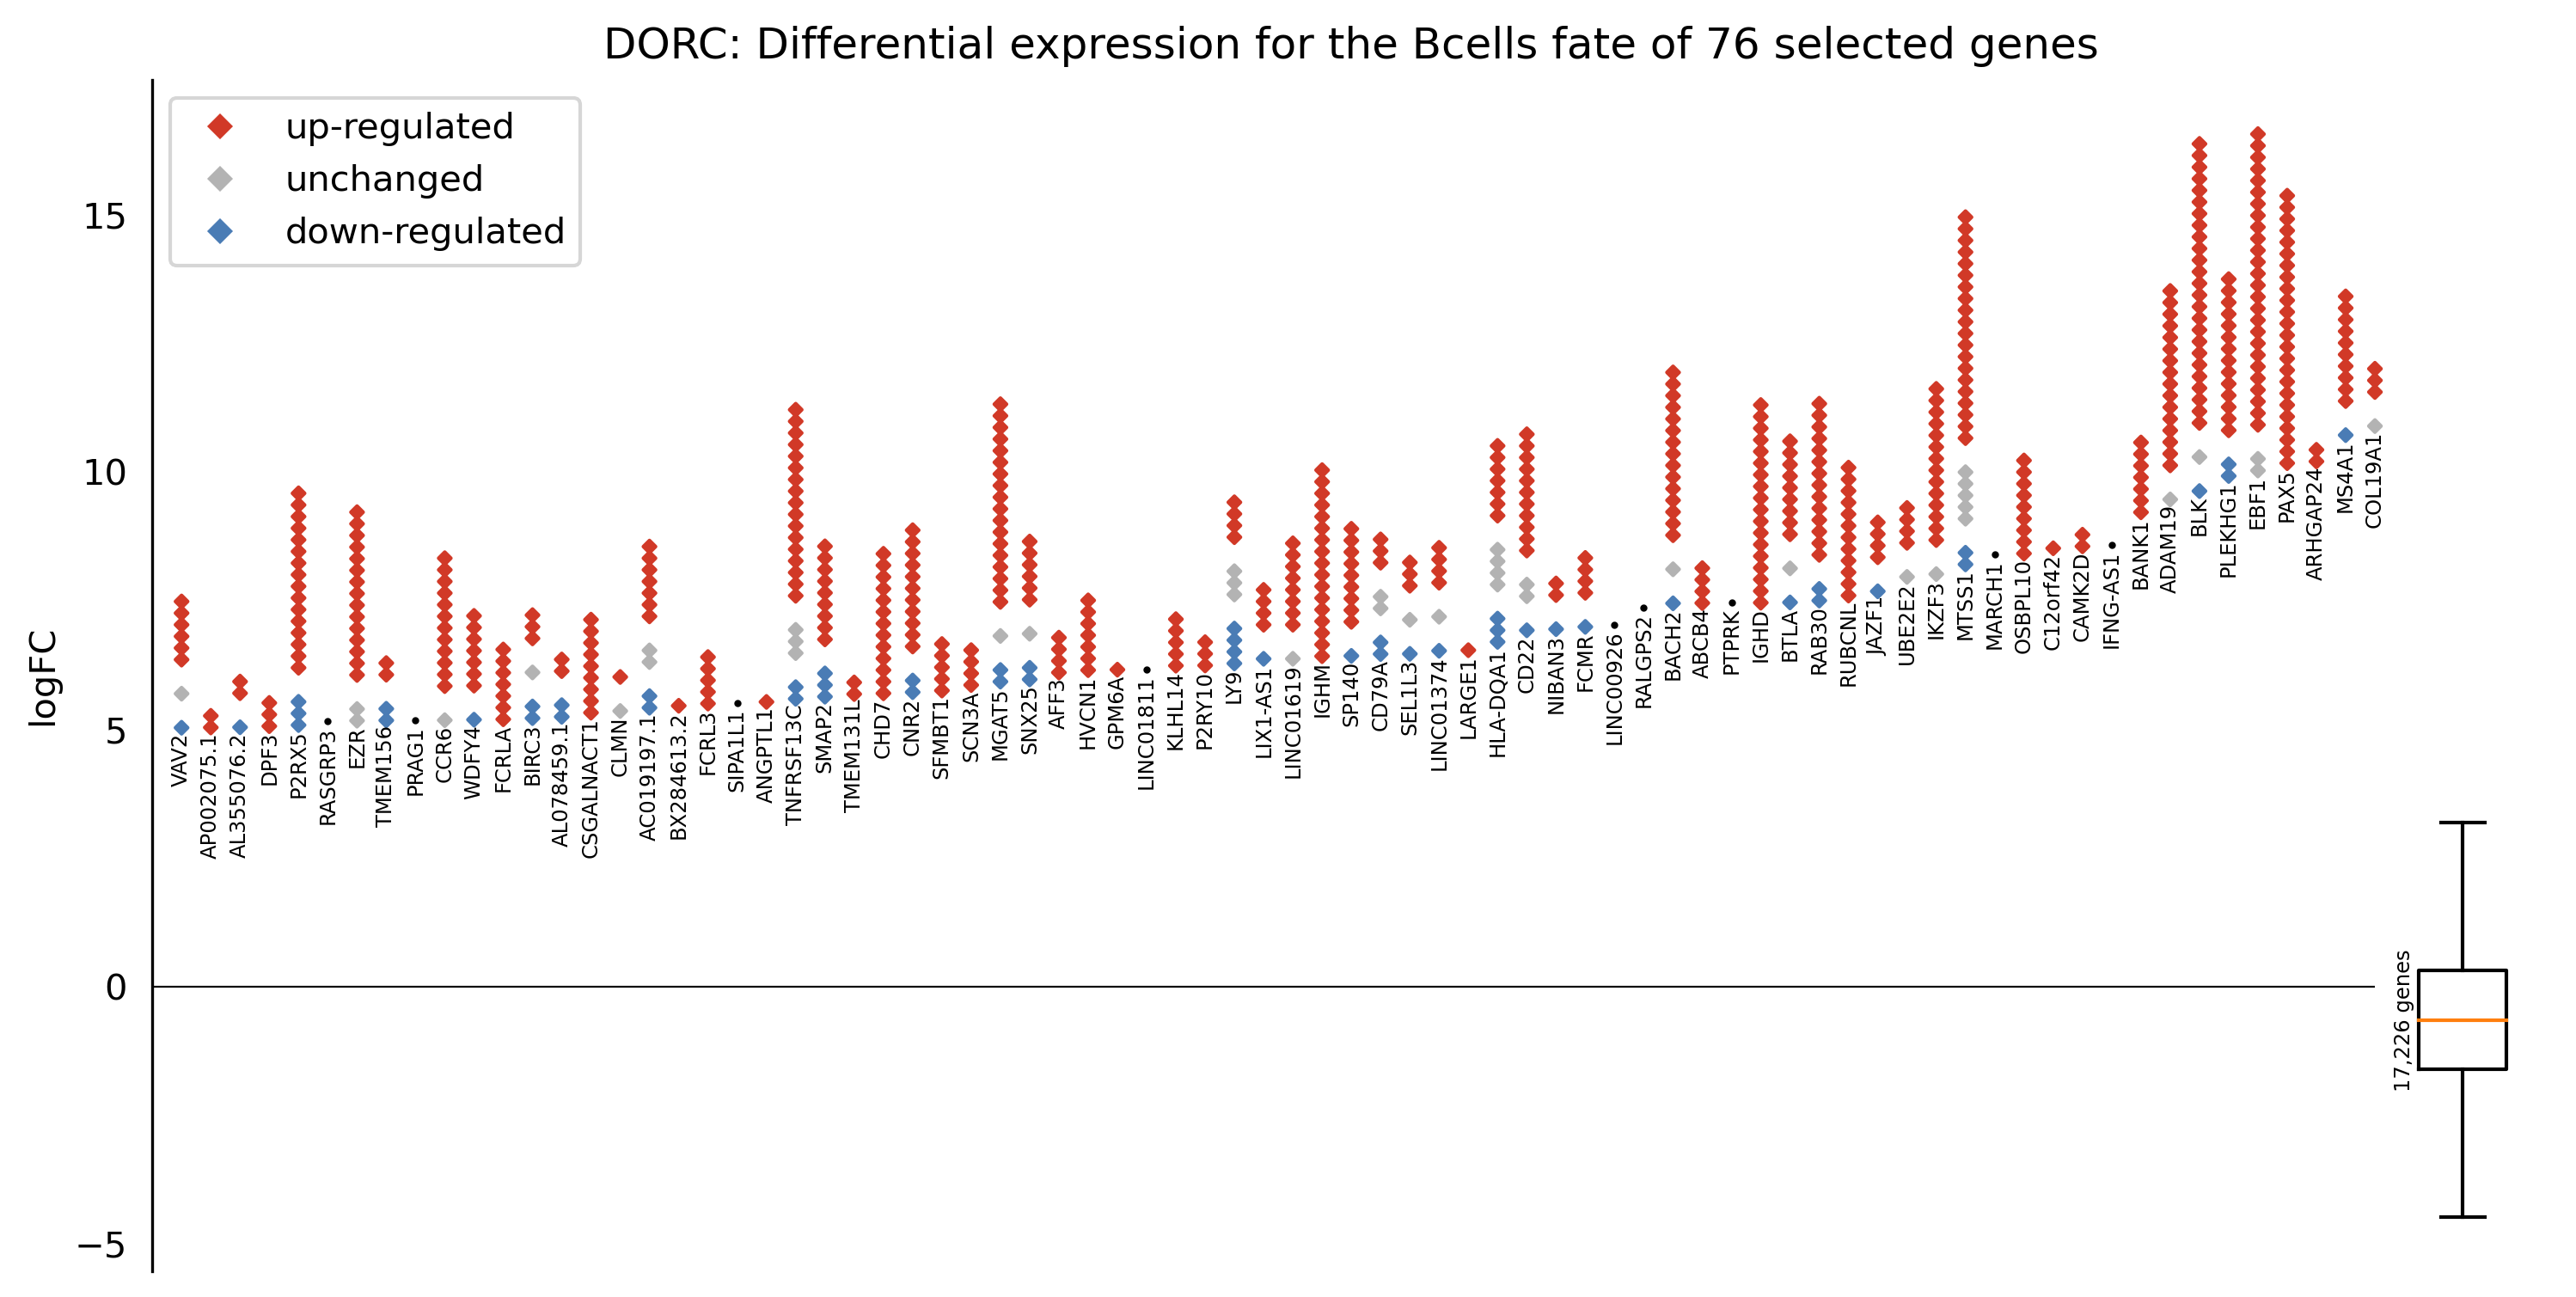

In [42]:
cmap, legend_elements = setup_cmap_and_legend(cmapdict, marker="D")
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    marker="D",
    point_distance=2e-2,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate of {n_selected_genes} selected genes"
)
plt.show()

# Multi subplots example

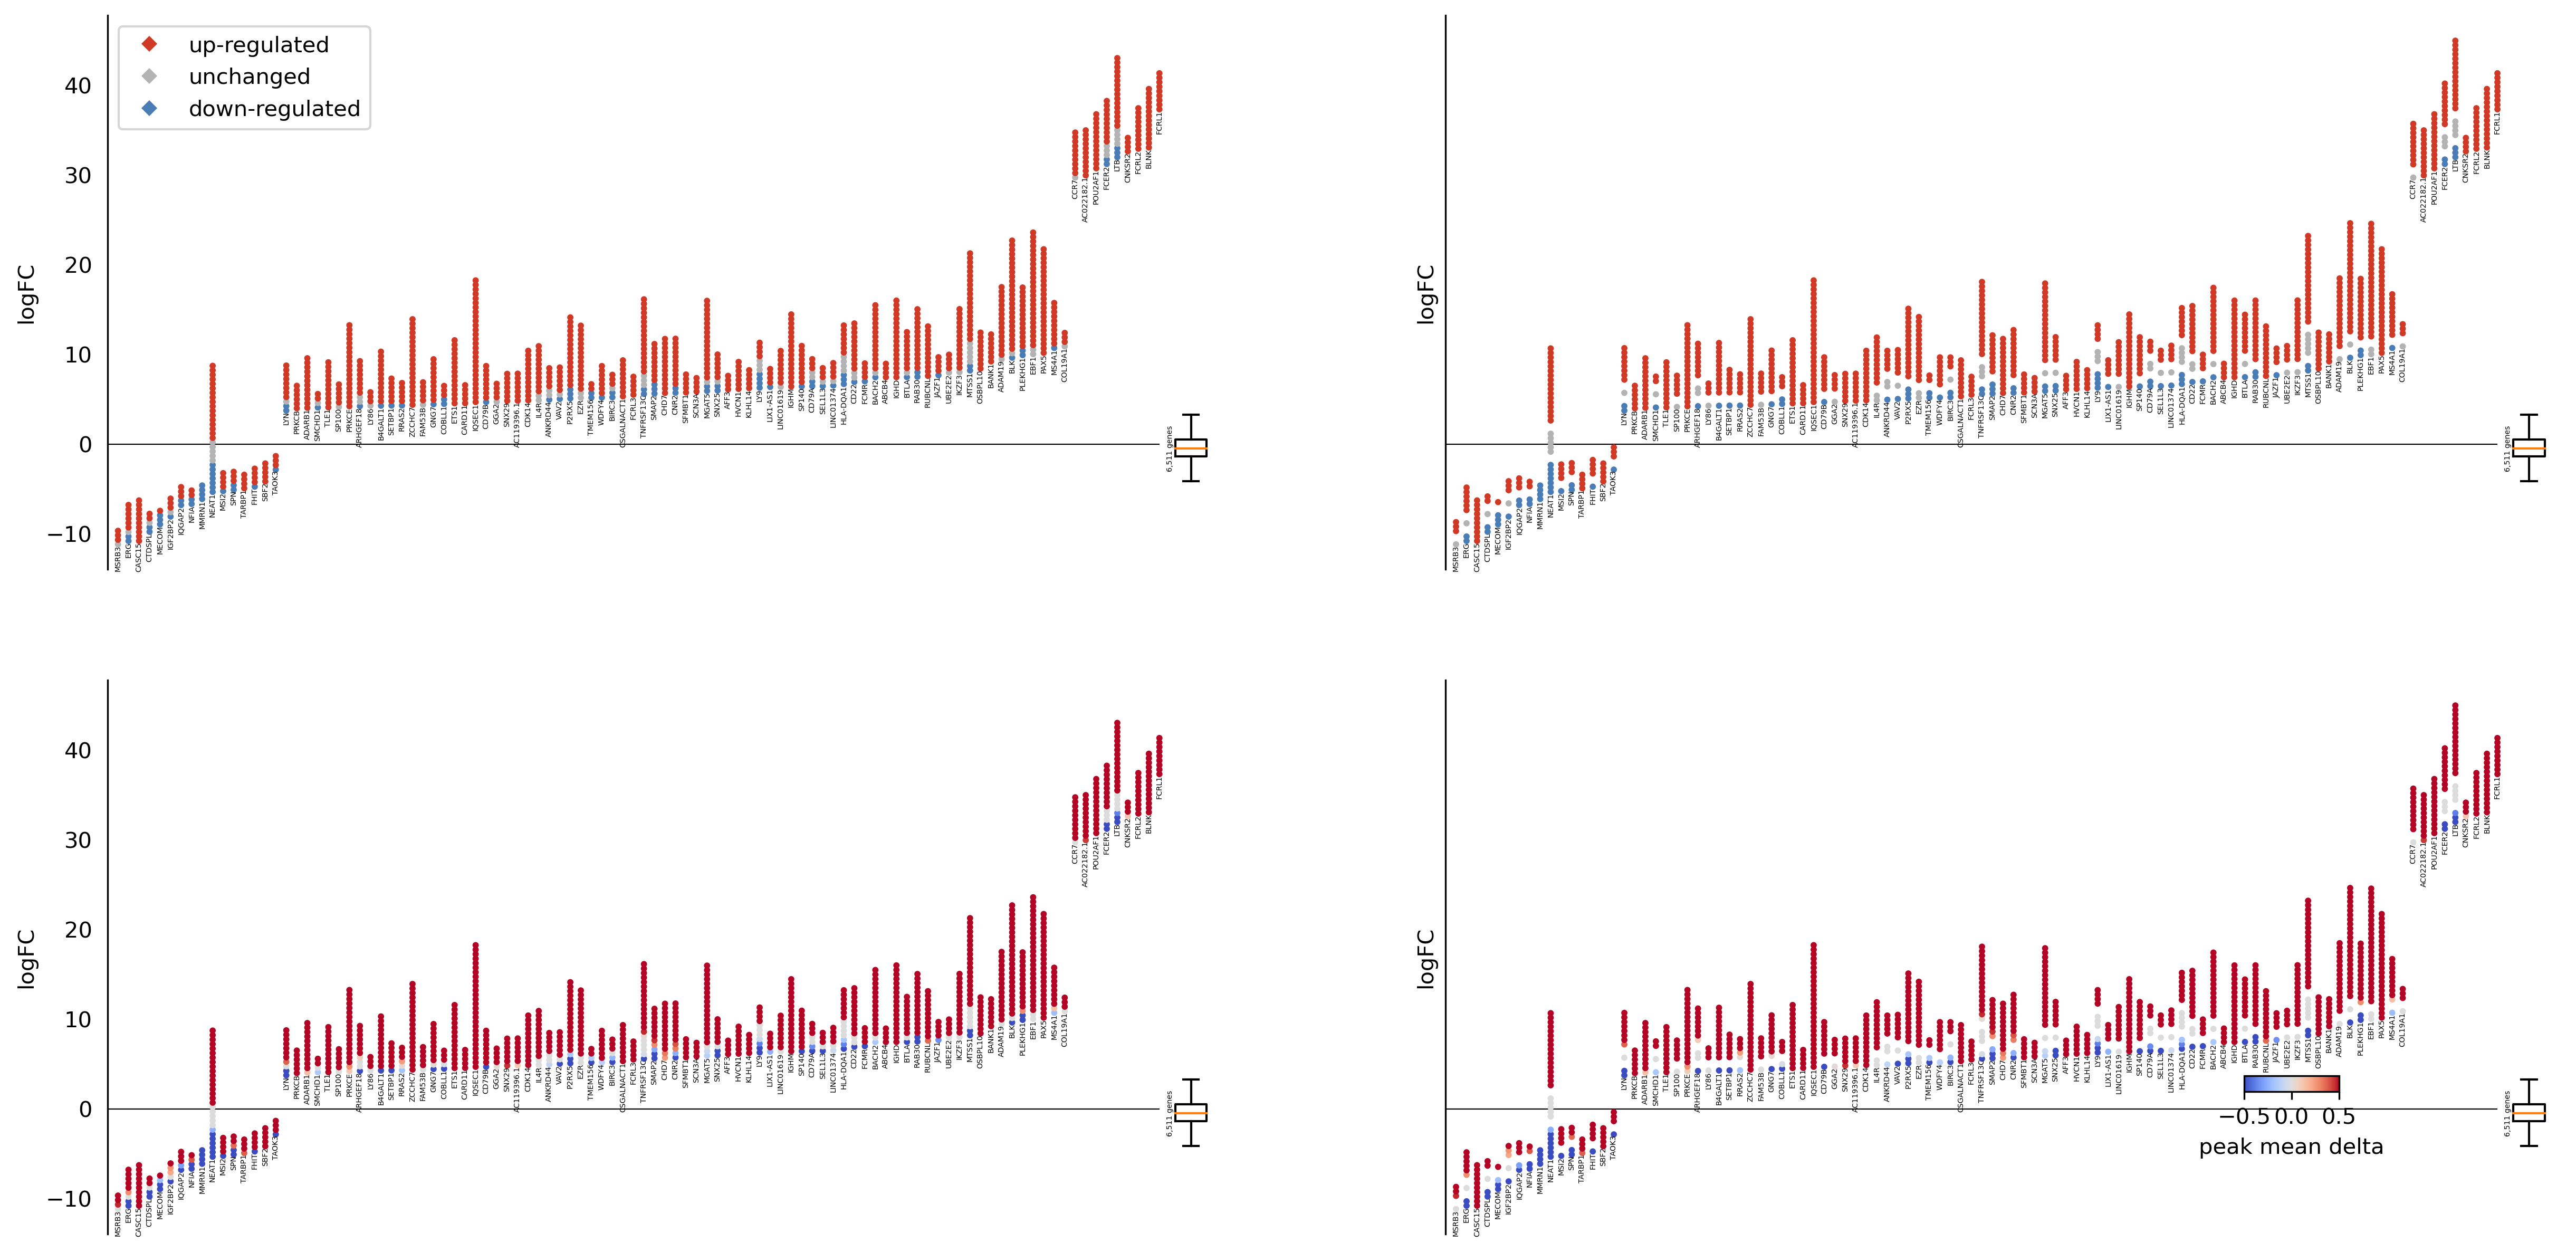

In [43]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))

# Plot using a discrete color scheme
enhancer_plot(
    gene_info_df,
    disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
    ax=axs[0, 0],
)
axs[0, 0].legend(handles=legend_elements, loc="upper left")

# Plot using a continuous color scheme
enhancer_plot(
    gene_info_df,
    cont_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    ax=axs[1, 0],
    color_bar_bounds=None,  # Disable colorbar
    vmin=-0.5,
    vmax=0.5,  # Normalize colors to range [-0.5, 0.5]
)

# Plot using a discrete color scheme and grouping the points
enhancer_plot(
    gene_info_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
    ax=axs[0, 1],
)

# Plot using a continuous color scheme and grouping the points
fig, ax, points = enhancer_plot(
    gene_info_df,
    cont_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    ax=axs[1, 1],
    color_bar_bounds=None,
    vmin=-0.5,
    vmax=0.5,
)

# Add a colorbar in the bottom right corner
cbar_axes = fig.add_axes([0.8, 0.2, 0.03, 0.01])
cbar = fig.colorbar(points, cax=cbar_axes, orientation="horizontal")
cbar.set_label("peak mean delta")

plt.show()